# Assignment || Naive Bayes on  Amazon Reviews Dataset || v1
#### By Rishiraj Adhikary For AppliedAIcourse.com || www.rishiraj.xyz@gmail.com

## Note
### The amazon data used here is the cleaned and text preprocessed data. Hence, no deduplication or text-preprocessing is done here. Make sure your data is clean and without duplicate entries before you execute this notebook

## Objective
### The following needs to be done

* Apply Naive Bayes
* Find the right value of hyper parameter alpha after cross validation
* Get accuracy, precision, recall, F1 score, confusion matrix


In [1]:
#initilaization for all the required packages
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc



from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn import cross_validation

/home/rishiraj/.local/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# using the SQLite Table to read data.
#final.sqlite is a cleaned deduped and preprocessed data
con = sqlite3.connect('final.sqlite') 


cleaned_data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", con) 

positiveNegative = cleaned_data['Score'] #Keeping labels/class in a different variable so that we can use it latercleaned_data.shape
cleaned_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...


In [3]:
#Helper function to print heatmap from confusionmatrix. 
#Source: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

#### We will have to reduce the data sets from 364K to 50K data sets of which 25K is positive and 25K is negative
#### This is done so as to speed up computation. 

In [4]:
#we will take first 1k positive reviews and first 1k negative reviews. Combine them to have a total of 2k text reviews
positiveData = cleaned_data[cleaned_data['Score'] == 'positive']
negativeData = cleaned_data[cleaned_data['Score'] == 'negative']
cleanedData_less = positiveData[:25000].append(negativeData[:25000])
len(cleanedData_less)
#the score corresponding to all 2k reviews
positiveNegativeLabel = cleanedData_less['Score']


#### We will sort the data on the basis of the timestamp

In [5]:
cleanedData_less.sort_values(by=['Time'], inplace=True, kind='quicksort', na_position='last')
positiveNegativeLabel = cleanedData_less['Score']


#### Dividing data into train and test set
SInce the data was sorted on basis of time, hence first 70% of data will be training data and rest30% will be test data. The line below accomplishes that

In [6]:
#70% training data and 30% test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(cleanedData_less['Text'].values, positiveNegativeLabel, test_size=0.3, random_state=0)

#### Text to vector conversion of train data using bag of words.  


In [7]:
#positiveNegativeLabel = cleanedData_less['Score']
count_vect = CountVectorizer() #in scikit-learn
X_train = count_vect.fit_transform(X_train)
X_train.get_shape()
print(type(X_train))

<class 'scipy.sparse.csr.csr_matrix'>


#### Applying 10-fold cross validation on training data using Bernoulli Naive Bayes

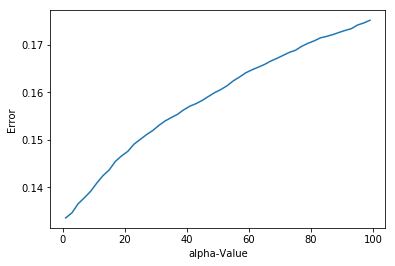


The optimal value of alpha is 1.


In [8]:
# creating odd list of alpha for Naive Bayes
from sklearn.naive_bayes import BernoulliNB


myList = list(range(0,100))
alpha_values = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for i in alpha_values:
    a = BernoulliNB(alpha=i)
    scores = cross_val_score(a, X_train, y_train, cv=10, scoring='accuracy') #accuracy measurement, not error
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

#plot the error curve
Y = np.array(MSE)
X = np.array(alpha_values)

plt.plot(X,Y)
plt.ylabel('Error')
plt.xlabel('alpha-Value')
plt.show()

# determining best k
optimal_alpha = alpha_values[MSE.index(min(MSE))]
print('\nThe optimal value of alpha is %d.' % optimal_alpha)



#### This optimal alpha will be used when we apply Bernoulli naive bayes on test data.
 

#### The test data needs to be converted into vector of same dimension as that of train data

In [9]:
#Converting X_test to vectors using BoW
#X_test_vectors = CountVectorizer() #in scikit-learn
X_test = count_vect.transform(X_test)
X_test.get_shape()

(15000, 40259)


The accuracy of the naive bayes classifier for alpha = 1 is 86.606667%


True Positive Rate =  89.36 %
True Negative Rate =  83.86 %
False Positive Rate =  16.14 %
False Negative Rate =  10.64 %


Precision Score =  84.69


Recall Score =  89.36


F1 Score =  86.96


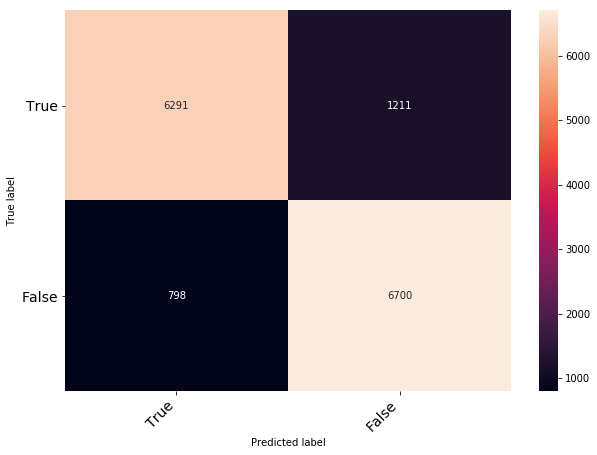

In [11]:
#applying bernoulli naives bayes on test data by training model on train data with optimal alpha
naive_optimal = BernoulliNB(alpha=optimal_alpha)

# fitting the model
naive_optimal.fit(X_train, y_train)


# predict the response
pred = naive_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the naive bayes classifier for alpha = %d is %f%%' % (optimal_alpha, acc))

#Code for Confusion Matrix (Raw)

#TN = True Negative
#FP = False Positive
#FN = False Negative
#TP = True Positive

TP = TN = FP = FN = 0;

for i in range(len(pred)):
    if pred[i] == y_test.values[i]:
        if pred[i] == 'positive':
            TP = TP + 1;
        else:
            TN = TN + 1;
    elif y_test.values[i] == 'negative' and pred[i] == 'positive':
        FP = FP + 1;
    else:
        FN = FN + 1;


#TN + FP = Total Actual Negative Points
#FN + TP = Total Actual Positive Points
print("\n")
print("True Positive Rate = ", round((TP/(TP+FN))*100,2),"%" )
print("True Negative Rate = ", round((TN/(FP+TN))*100,2),"%" )
print("False Positive Rate = ", round((FP/(FP+TN))*100,2),"%" )
print("False Negative Rate = ", round((FN/(TP+FN))*100,2),"%" )
print("\n")
precision = round((TP/(TP+FP))*100,2)
recall = round((TP/(TP+FN))*100,2)
print("Precision Score = ", precision)
print("\n")
print("Recall Score = ", recall)
print("\n")
print("F1 Score = ", round((2*(precision*recall)/(precision+recall)),2))

#Code For Confusion Matrix Using Sklearn
#he count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.
from sklearn.metrics import confusion_matrix
cfs_matrix = confusion_matrix(y_test.values, pred)
class_names = ['True', 'False']

print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)



## Result:
Usinng BOW, the accuracy attained is 86.61% with hyperparameter alpha as 1


## ---------------------------------------------------------------------------------------------------------------

#### Text to vector conversion using TF-IDF on train data. 


In [12]:
#70% training data and 30% test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(cleanedData_less['Text'].values, positiveNegativeLabel, test_size=0.3, random_state=0)

In [13]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(X_train)
type(final_tf_idf)


scipy.sparse.csr.csr_matrix

#### Applying 3-fold cross validation on training data with Multinomial Naive Bayes

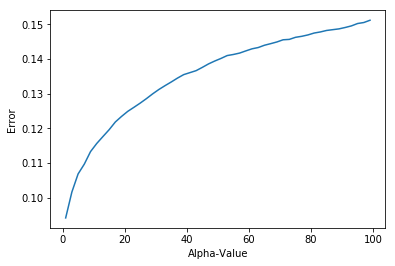


The optimal number of neighbors is 1.


In [14]:
# creating odd list of K for KNN
myList = list(range(0,100))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

from sklearn.naive_bayes import MultinomialNB

# empty list that will hold cv scores
alpha_scores = []

# perform 10-fold cross validation
for i in neighbors:
    a = MultinomialNB(alpha=i)
    scores = cross_val_score(a, final_tf_idf, y_train, cv=3, scoring='accuracy') #accuracy measurement, not error
    alpha_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in alpha_scores]

#plot the error curve
Y = np.array(MSE)
X = np.array(neighbors)

plt.plot(X,Y)
plt.ylabel('Error')
plt.xlabel('Alpha-Value')
plt.show()

# determining best k
optimal_alpha = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_alpha)

#### The test data needs to be converted into vector of same dimension as that of train data

In [15]:
final_tf_idf_test = tf_idf_vect.transform(X_test)
type(final_tf_idf_test)

scipy.sparse.csr.csr_matrix

#### The optimal alpha will be used as optimal alpha for Multinomial Naive Bayes for the test data set to predict the response and evaluate accuracy



The accuracy of the multinomial classifier for alpha = 1 is 90.966667%


True Positive Rate =  88.89 %
True Negative Rate =  93.04 %
False Positive Rate =  6.96 %
False Negative Rate =  11.11 %


Precision Score =  92.74


Recall Score =  88.89


F1 Score =  90.77


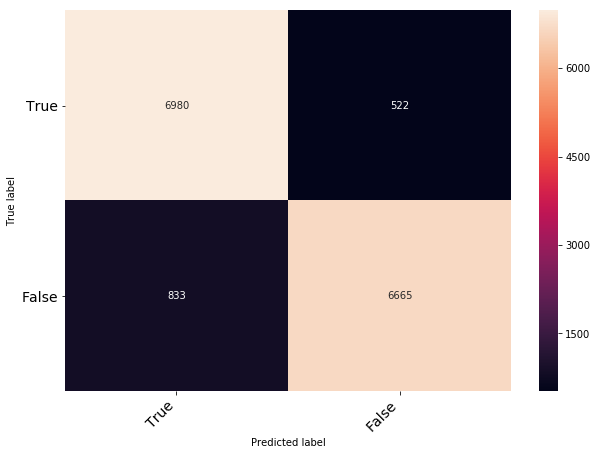

In [16]:
alpha_optimal = MultinomialNB(alpha=optimal_alpha)

# fitting the model
alpha_optimal.fit(final_tf_idf, y_train)

# predict the response
pred = alpha_optimal.predict(final_tf_idf_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the multinomial classifier for alpha = %d is %f%%' % (optimal_alpha, acc))


#Code for Confusion Matrix

#TN = True Negative
#FP = False Positive
#FN = False Negative
#TP = True Positive

TP = TN = FP = FN = 0;

for i in range(len(pred)):
    if pred[i] == y_test.values[i]:
        if pred[i] == 'positive':
            TP = TP + 1;
        else:
            TN = TN + 1;
    elif y_test.values[i] == 'negative' and pred[i] == 'positive':
        FP = FP + 1;
    else:
        FN = FN + 1;


#TN + FP = Total Actual Negative Points
#FN + TP = Total Actual Positive Points
print("\n")
print("True Positive Rate = ", round((TP/(TP+FN))*100,2),"%" )
print("True Negative Rate = ", round((TN/(FP+TN))*100,2),"%" )
print("False Positive Rate = ", round((FP/(FP+TN))*100,2),"%" )
print("False Negative Rate = ", round((FN/(TP+FN))*100,2),"%" )

print("\n")
precision = round((TP/(TP+FP))*100,2)
recall = round((TP/(TP+FN))*100,2)
print("Precision Score = ", precision)
print("\n")
print("Recall Score = ", recall)
print("\n")
print("F1 Score = ", round((2*(precision*recall)/(precision+recall)),2))

#Code For Confusion Matrix Using Sklearn
#he count of true negatives is C_{0,0}, false negatives is C_{1,0}, true positives is C_{1,1} and false positives is C_{0,1}.
from sklearn.metrics import confusion_matrix

cfs_matrix = confusion_matrix(y_test.values, pred)
class_names = ['True', 'False']

print_confusion_matrix(cfs_matrix, class_names, figsize = (10,7), fontsize=14)


## Result:
Usinng TF-IDF, the accuracy attained is 90.96% with Aplha as 1 in Multinomial Naive Bayes

## ------------------------------------------------------------------------------------------------------------------

## Conclusion
#### * Multinomial Naive Bayes performed better on our Amazon Food Review dataset with an accuracy of 90.96%. 
#### * Multinomial Naive Bayes considers the number of time a word appears in a review. Words like "good" if appears multiple times can positively bayes our result hence multinomila biasing makes more sense for Amazon Fine Food dataset.



Point to note: We applied 10 fold cross validation on training data where the vectors were generated using Bag of words. For all other, we have used 3 fold cross validation to speed up computation. 
